In [4]:
import pandas as pd

# Read the CSV file into a DataFrame
column_names = ["text", "is_hate"]

df = pd.read_csv('1.preprocessed_data.csv', on_bad_lines='skip', sep=",", encoding='iso-8859-1', header=0, names=column_names)
df['is_hate'] = df['is_hate'].astype(bool)
df['text'] = df['text'].astype('str')
df.head()

,text,is_hate
0,ponnayo danne kellek aduwa gaman laga inna kol...,True
1,ape harak samjeta eka honda adrshyak,False
2,tpita pisuda yako man htuwe atta kiyala aiyo,False
3,kimbak eduwoth ape untath amma thaththawath pe...,True
4,lisan nathawa yanna puluwan yako api dannawa o...,False


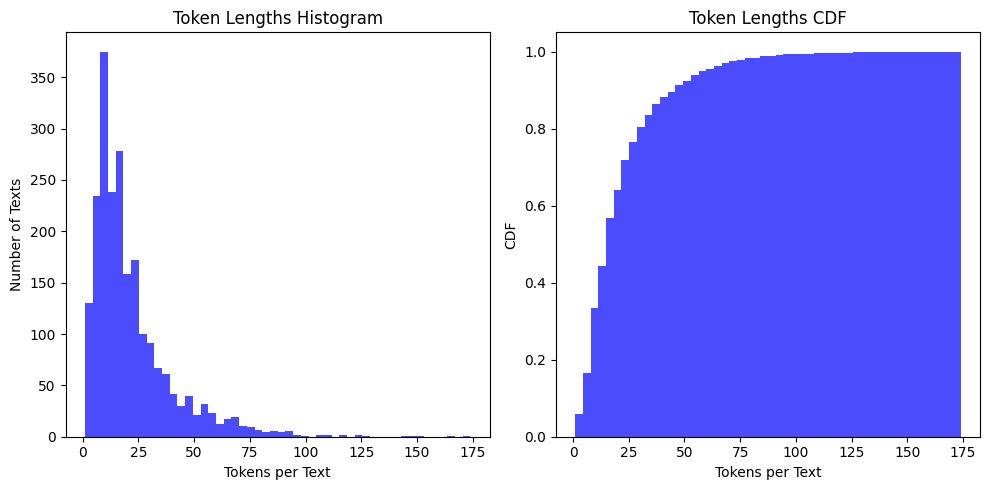

To cover 100% of the data, set max_length to 174.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer

# Assume df already exists
# df = pd.read_csv('your_file.csv')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Calculate token lengths
token_lengths = df['text'].apply(lambda x: len(tokenizer.tokenize(x)))

# Plot histogram
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(token_lengths, bins=50, facecolor='blue', alpha=0.7)
plt.title('Token Lengths Histogram')
plt.xlabel('Tokens per Text')
plt.ylabel('Number of Texts')

# Plot CDF
plt.subplot(1, 2, 2)
plt.hist(token_lengths, bins=50, facecolor='blue', alpha=0.7, cumulative=True, density=True)
plt.title('Token Lengths CDF')
plt.xlabel('Tokens per Text')
plt.ylabel('CDF')

plt.tight_layout()
plt.show()

# Determine optimal max_length based on desired coverage
desired_coverage = 1
optimal_max_length = int(token_lengths.quantile(desired_coverage))
print(f"To cover {desired_coverage*100}% of the data, set max_length to {optimal_max_length}.")


In [5]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import optuna

# Assume df already exists
# df = pd.read_csv('your_file.csv')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 256

def tokenize_data(texts, tokenizer, max_length):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')


def objective(trial):
    tokens = tokenize_data(df['text'].tolist(), tokenizer, max_length)
    dataset = TensorDataset(tokens.input_ids, tokens.attention_mask, torch.tensor(df['is_hate'].values).long())

    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-4)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    epochs = trial.suggest_int('epochs', 2, 5)
    dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Model with dropout tuning
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
    
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False):
            input_ids, attention_mask, labels = batch
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

    # Validation
    model.eval()
    total_val_loss = 0
    for batch in tqdm(val_loader, desc="Validation", leave=False):
        input_ids, attention_mask, labels = batch
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        total_val_loss += outputs.loss.item()

    return total_val_loss / len(val_loader)


study = optuna.create_study(direction='minimize')  # minimize validation loss
study.optimize(objective, n_trials=50)

print(study.best_params)


[I 2023-10-07 13:58:57,667] A new study created in memory with name: no-name-113d9676-9bbd-4144-8efe-0631c53ea0cf
/var/folders/db/ncrc7r_d6236t8njwz8ddy300000gn/T/ipykernel_6875/4097411717.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-4)
/var/folders/db/ncrc7r_d6236t8njwz8ddy300000gn/T/ipykernel_6875/4097411717.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
[W 2023-10-07 13:59:52,635] Trial 0 failed with parameters: {'lr': 1.0783895279691702e-05, 'batch_size': 32, 'epochs': 5, 'dropout': 0.10940690612883919} because of the following error: TypeError("BertForSequenceClassifi

TypeError: BertForSequenceClassification.__init__() got an unexpected keyword argument 'dropout'

In [3]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from torch.nn.functional import softmax

# Assuming df already exists
# If reading from a file:
# df = pd.read_csv('your_file.csv')

# Tokenize the texts
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 256

def tokenize_data(texts, tokenizer, max_length):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

tokens = tokenize_data(df['text'].tolist(), tokenizer, max_length)

# Create a DataLoader
dataset = TensorDataset(tokens.input_ids, tokens.attention_mask, torch.tensor(df['is_hate'].values).long())
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Training setup
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):  # <-- Note the change here
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader)}")

# Validation
model.eval()
all_preds = []
all_labels = []
all_probs = []

for batch in tqdm(val_loader, desc="Validation"):  # <-- Note the change here
    input_ids, attention_mask, labels = batch
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
    probabilities = softmax(logits, dim=1)
    all_probs.extend(probabilities[:, 1].numpy())
    preds = torch.argmax(logits, dim=1).tolist()
    all_preds.extend(preds)
    all_labels.extend(labels.tolist())

print("Validation Accuracy:", accuracy_score(all_labels, all_preds))
report = classification_report(all_labels, all_preds)
print(report)

# Prediction function
def predict(text, model, tokenizer):
    model.eval()
    tokens = tokenize_data([text], tokenizer, max_length)
    with torch.no_grad():
        logits = model(tokens['input_ids'], attention_mask=tokens['attention_mask']).logits
    return torch.argmax(logits, dim=1).item()

# Sample prediction
text = "Your sample text here"
result = predict(text, model, tokenizer)
print("Hateful" if result == 1 else "Not hateful")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/4 | Loss: 0.6311615770382266


Epoch 2: 100%|██████████| 124/124 [10:00<00:00,  4.84s/it]


Epoch 2/4 | Loss: 0.4245388446555984


Epoch 3: 100%|██████████| 124/124 [10:25<00:00,  5.04s/it]


Epoch 3/4 | Loss: 0.2666336266143668


Epoch 4: 100%|██████████| 124/124 [09:43<00:00,  4.71s/it]


Epoch 4/4 | Loss: 0.17427466999018384


Validation: 100%|██████████| 14/14 [00:14<00:00,  1.04s/it]

Validation Accuracy: 0.8235294117647058
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       129
           1       0.81      0.75      0.78        92

    accuracy                           0.82       221
   macro avg       0.82      0.81      0.82       221
weighted avg       0.82      0.82      0.82       221

Not hateful


It took 43 mins

In [4]:
# Sample prediction
text = "kalakanni deshapaluwo"
result = predict(text, model, tokenizer)
print("Hateful" if result == 1 else "Not hateful")

Hateful


In [7]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import pickle
import numpy as np

report = classification_report(all_labels, all_preds, target_names=['True', 'False'])
# values for confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize the confusion matrix

# values for ROC curve
# Convert model output to probabilities and plot ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# save the values to a file
with open('2.11 Bert.pkl', 'wb') as f:
    pickle.dump({
        'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc, 'cm_percentage': cm_percentage, 'report': report
    }, f)